# 1. Preprocess/enhance the image

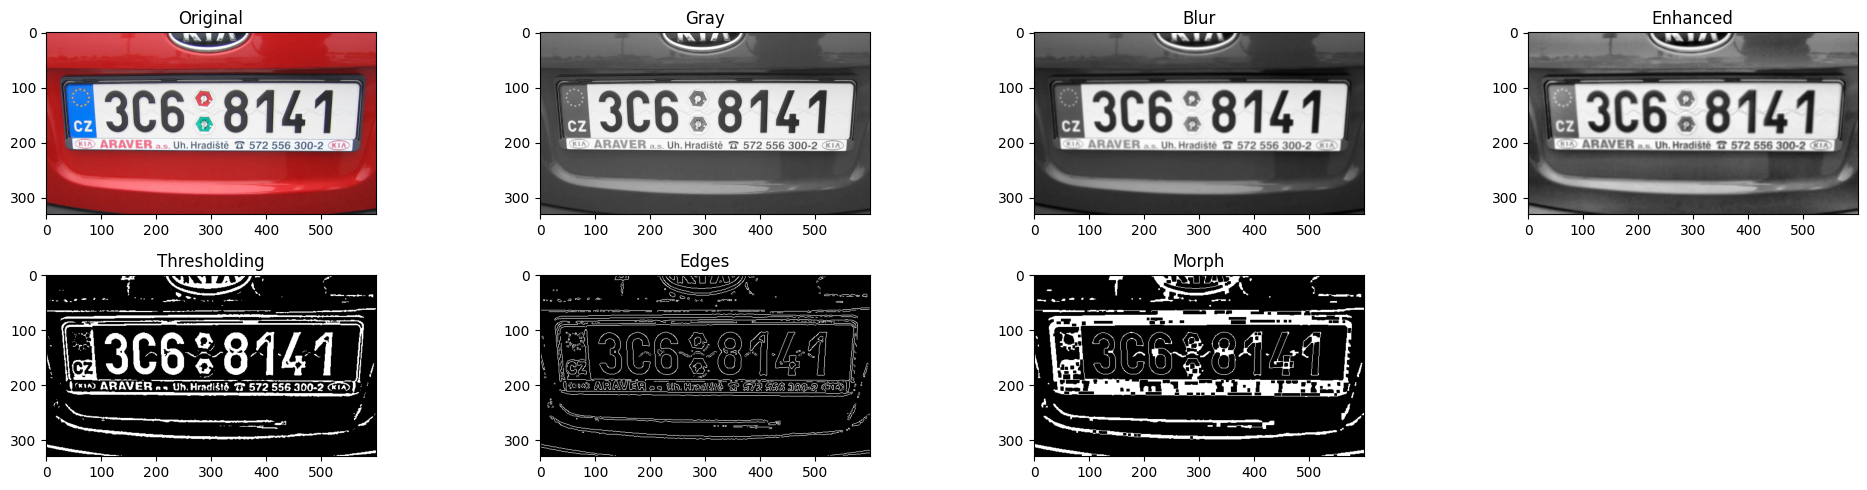

In [312]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img_path = "img\\tsjechie52.jpg"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(blurred)

thresh = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 19, 9)

edges = cv2.Canny(thresh, 50, 200)

kernel = np.ones((3, 3), np.uint8)
morph = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)


plt.figure(figsize=(20,5))
plt.subplot(241); plt.imshow(img_rgb);plt.title('Original')
plt.subplot(242); plt.imshow(img_gray, cmap="gray");plt.title('Gray')
plt.subplot(243); plt.imshow(blurred, cmap="gray");plt.title('Blur')
plt.subplot(244); plt.imshow(enhanced, cmap="gray");plt.title('Enhanced')
plt.subplot(245); plt.imshow(thresh, cmap="gray");plt.title('Thresholding')
plt.subplot(246); plt.imshow(edges, cmap="gray");plt.title('Edges')
plt.subplot(247); plt.imshow(morph, cmap="gray");plt.title('Morph')
plt.tight_layout()

# 2. Recognize the plate - basic Haar cascade detection

In [ ]:
plate_cascade = cv2.CascadeClassifier("models/haarcascade_russian_plate_number.xml")
# plate_cascade = cv2.CascadeClassifier("models/indian_license_plate.xml")

def recognize_plate(img_enh, img_original):
    img_copy = img_original.copy()
    plate_crop = img_copy

    plates = plate_cascade.detectMultiScale(img_enh, scaleFactor=1.1, minNeighbors=7)

    if not len(plates) == 0:
        return None

    for x, y, w, h in plates:
        # Draw a rectangle around detected plate
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 5)

        # Crop the plate region
        plate_crop = img_copy[y : y + h, x : x + w]

    return img_copy, plate_crop

In [313]:
#img_path = "img\\tsjechie52.jpg"
#img = cv2.imread(img_path)
#img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(recognize_plate(img_gray, img_rgb)[0])

TypeError: 'NoneType' object is not subscriptable

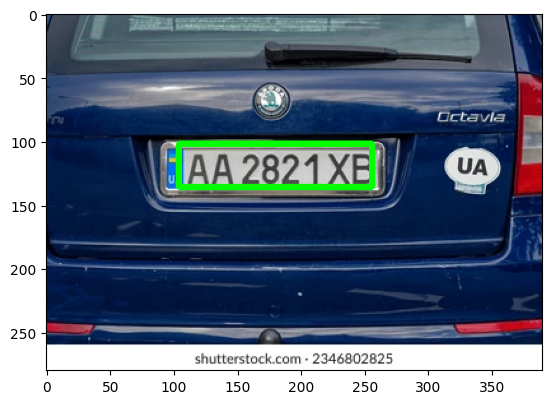

In [266]:
img_copy2 = img_rgb.copy()
plate_img = img_rgb.copy()
roi = img_rgb.copy()
plate_rect = plate_cascade.detectMultiScale(img_gray, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
for (x,y,w,h) in plate_rect:
    roi_ = roi[y:y+h, x:x+w] # extracting the Region of Interest of license plate for blurring.
    plate = roi[y:y+h, x:x+w]
    cv2.rectangle(
        img_copy2, (x + 2, y), (x + w - 3, y + h - 5), (0, 255, 0), 3
    )  # finally representing the detected contours by drawing rectangles around the edges.

plt.imshow(img_copy2)

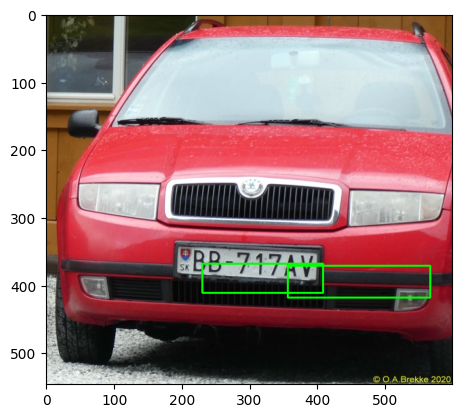

In [258]:
import cv2
import numpy as np

# Load the pre-trained EAST text detection model
east_model = "models/frozen_east_text_detection.pb"
net = cv2.dnn.readNet(east_model)

img = img_rgb.copy()
(H, W) = img.shape[:2]

# Resize to fit model input size
newW, newH = (320, 320)
rW, rH = W / float(newW), H / float(newH)
image = cv2.resize(img, (newW, newH))

blob = cv2.dnn.blobFromImage(
    image, 1.0, (newW, newH), (123.68, 116.78, 103.94), swapRB=True, crop=False
)
net.setInput(blob)

(scores, geometry) = net.forward(
    ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
)

rects = []
confidences = []

for y in range(scores.shape[2]):
    for x in range(scores.shape[3]):
        score = scores[0, 0, y, x]
        if score < 0.5:  # Ignore weak detections
            continue

        offsetX, offsetY = x * 4.0, y * 4.0
        angle = geometry[0, 4, y, x]
        cosA, sinA = np.cos(angle), np.sin(angle)

        h = geometry[0, 0, y, x] + geometry[0, 2, y, x]
        w = geometry[0, 1, y, x] + geometry[0, 3, y, x]

        endX = int(offsetX + (cosA * w) + (sinA * h))
        endY = int(offsetY - (sinA * w) + (cosA * h))
        startX = int(endX - w)
        startY = int(endY - h)

        rects.append((startX, startY, endX, endY))
        confidences.append(score)

# Apply Non-Maximum Suppression (NMS)
indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

if len(indices) > 0:
    for i in indices.flatten():
        (startX, startY, endX, endY) = rects[i]

        # Scale back to original size
        startX, startY, endX, endY = (
            int(startX * rW),
            int(startY * rH),
            int(endX * rW),
            int(endY * rH),
        )

        # Draw detected region
        cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
        plate_crop = img[startY:endY, startX:endX]

plt.imshow(img)

# 3. Crop and preprocess the recognized plate

# 4. Split the plate into characters and apply OCR

# 5. Validate and post-process